# CS5830 Naive Bayes
Chetan, Zion Steiner

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import praw

### Subreddits
* AskReddit
* WritingPrompts
* TIL
* WorldNews
* UnethicalLifeProTips

### Procedure
1. Collect the 500 top posts titles from each subreddit.
2. Construct feature sets from post title
    * Count Matrix
    * Tfidf Matrix
3. Compare naive bayes performance

In [3]:
# Init API with credentials
reddit = praw.Reddit(client_id='IyeHu8CuF0DQhw',
                     client_secret="aaG9Z5FJpv0dHEBWnUmrNnpC0jU", password='Bluetomcat101',
                     user_agent='script:naiveBayesClassification:v1.0.0 (by /u/aquaticLumbar)', username='aquaticLumbar')

In [21]:
subs = ['AskReddit', 'WritingPrompts', 'todayilearned', 'worldnews', 'UnethicalLifeProTips']

In [5]:
# Collect post titles
df_title = pd.DataFrame(columns=['subreddit', 'title'])
for sub in subs:
    subreddit = reddit.subreddit(sub)
    for post in subreddit.top('all', limit=500):
        df = df.append({'subreddit': sub,
                        'title': post.title.lower()}, ignore_index=True)

In [22]:
df_title.head()

,subreddit,title,word_count
0,AskReddit,"people who haven't pooped in 2019 yet, why are...",17
1,AskReddit,how would you feel about a feature where if so...,19
2,AskReddit,stan lee has passed away at 95 years old,9
3,AskReddit,would you watch a show where a billionaire ceo...,38
4,AskReddit,"reddit, how would you feel about a law that ba...",20


In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate

def naive_bayes(X, y, report=True):
    results = cross_validate(estimator=MultinomialNB(),
                         X=X,
                         y=y,
                         scoring=['f1_weighted', 'precision_weighted', 'recall_weighted', 'accuracy'], 
                         cv=10, 
                         return_train_score=False)
    
    for metric in results.keys():
        results[metric] = np.mean([result for result in results[metric] if result > 0])
    
    # Confusion matrix
    y_true = y

    clf = MultinomialNB()
    clf.fit(X, y_true)
    y_pred = clf.predict(X)

    if report:
        plt.figure(figsize=(8, 8))
        ax = sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred, labels=subs), index=subs, columns=subs), annot=True, fmt='')
        ax.set_title('Confusion Matrix')

    f1 = sklearn.metrics.f1_score(y_true, y_pred, average='macro')
    
    if report:
        print('Results')
        print('--------------')
        for metric, value in results.items():
            print(f'{metric.title()}, {value}')
        print()
        print('Entire Dataset f1: ', f1)
    
    return f1

Results
--------------
Fit_Time, 0.00689542293548584
Score_Time, 0.004004931449890137
Test_F1_Weighted, 0.9031263488081578
Test_Precision_Weighted, 0.9152243789951255
Test_Recall_Weighted, 0.9048
Test_Accuracy, 0.9048

Entire Dataset f1:  0.9823502444230277


0.9823502444230277

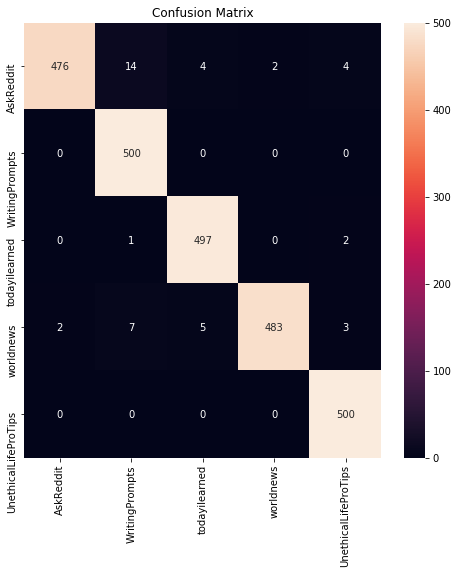

In [27]:
# Count Matrix (Naive features)
from sklearn.feature_extraction.text import CountVectorizer

count_matrix = CountVectorizer().fit_transform(df_title['title'])
naive_bayes(count_matrix, df_title['subreddit'])

Results
--------------
Fit_Time, 0.005426859855651856
Score_Time, 0.003134322166442871
Test_F1_Weighted, 0.8772561295160084
Test_Precision_Weighted, 0.8906171476290297
Test_Recall_Weighted, 0.8784000000000001
Test_Accuracy, 0.8784000000000001

Entire Dataset f1:  0.978004969729166


0.978004969729166

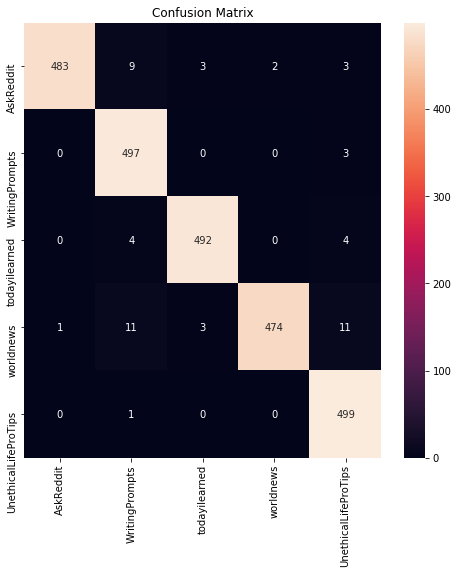

In [28]:
# Term Frequency-Inverse Document Frequency Matrix
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer().fit_transform(df_title['title'])
naive_bayes(tfidf, df_title['subreddit'])

### It seems like word count works slightly better than *tfidm*. Why?

It's possible that important information is lost when the *tfidm* is taken of short documents. Because there are fewer words, maybe values assigned to certain words of importance are overly penalized in *tfidm*. This might lead to a disproportiate effect related to corpus length. 

One example of certain words being overly penalized is words whose interpretation is context-dependent. Context-dependent words might occur more frequently than other words in a corpus because they can be used to have different meanings. However, they are separated from their semantic meaning when counted. The information about their relevance across the corpus is then disproportionately penalized by the document inverse term.

To test this, model performance on both feature sets was collected for post titles stratified by length in words.

/home/zion/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


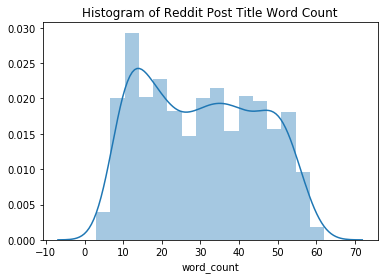

In [14]:
df_title['word_count'] = df_title['title'].str.split().apply(lambda x: len(x))
df_title.to_csv('data/titles.csv')

sns.distplot(df_title['word_count']).set_title('Histogram of Reddit Post Title Word Count')
plt.savefig('imgs/wordCountHist.png')

The word count distribution looks uniformly spread with a mode somewhere between 10-15 words. We'll partition the data by word count ranges of 10.

In [29]:
df_title['word_count'].max() - df_title['word_count'].min()

59

Six groups.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings

warnings.filterwarnings(action='ignore')

df_title.sort_values(by='word_count', inplace=True)

count_f1 = [[], []]
tfidf_f1 = [[], []]

inc = 10
for x in range(0, 51, inc):
    data = df_title.loc[(df_title['word_count'] >= x) & (df_title['word_count'] < x+10)]
    
    count_matrix = CountVectorizer().fit_transform(data['title'])
    count_f1[0].append(x)
    count_f1[1].append(naive_bayes(count_matrix, data['subreddit'], report=False))

    tfidf = TfidfVectorizer().fit_transform(data['title'])
    tfidf_f1[0].append(x)
    tfidf_f1[1].append(naive_bayes(tfidf, data['subreddit'], report=False))

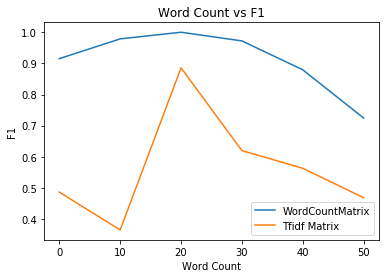

In [31]:
# Plot
# fig, axs = plt.subplots((2, 1), figsize=(8, 8))
ax = sns.lineplot(x=count_f1[0], y=count_f1[1], label='WordCountMatrix')
ax = sns.lineplot(x=tfidf_f1[0], y=tfidf_f1[1], ax=ax, label='Tfidf Matrix')
ax.set_title('Word Count vs F1')
ax.set(xlabel='Word Count', ylabel='F1')
ax.legend()
plt.savefig('imgs/wordCountVF1.png')

It looks like choice of feature set does effect different word count ranges differently. However, the exact mechanism is unknown. 

### Future work
* It would be interesting to compare these results to another test but on longer documents. 
* Would average word length or number of words in title be effectice predictive features for subreddit? 

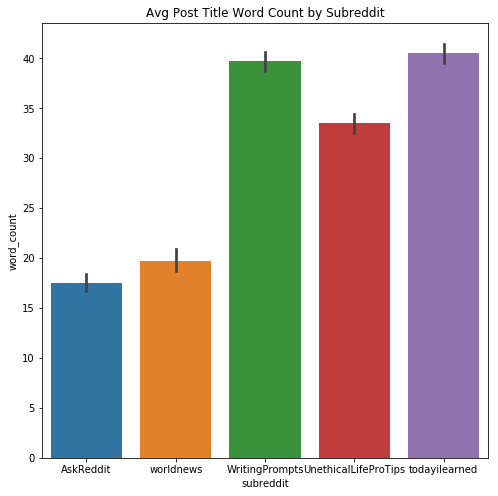

In [32]:
plt.figure(figsize=(8, 8))
sns.barplot(x='subreddit', y='word_count', data=df_title).set_title('Avg Post Title Word Count by Subreddit')
plt.savefig('imgs/word_count_bar.png')

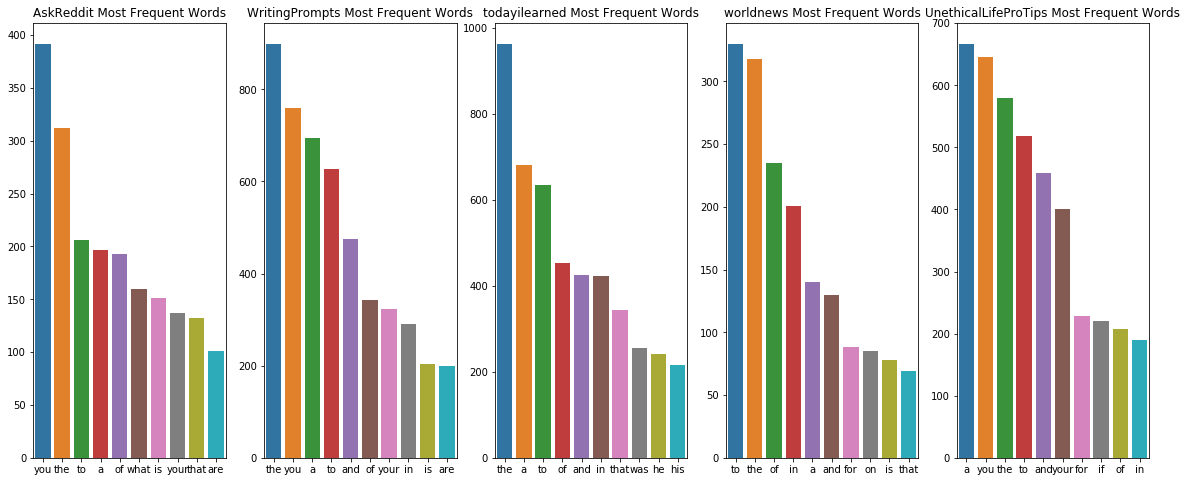

In [33]:
# Top ten words by sub
from collections import defaultdict

fig, axs = plt.subplots(1, 5, figsize=(20, 8))
for i,ax in enumerate(axs):
    data = df_title.loc[df_title['subreddit'] == subs[i]]
    
    corpus = ''
    for title in data['title']:
        corpus += title
    
    word_freq_dict = defaultdict(int)
    for word in corpus.split():
        word_freq_dict[word] += 1
        
    x = []
    y = []
    
    for word, count in sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True):
        x.append(word)
        y.append(count)        
    
    sns.barplot(x=x[:10], y=y[:10], ax=axs[i]).set_title(f'{subs[i]} Most Frequent Words')
    
plt.savefig('imgs/ind_word_count_bar.png')

Mostly useless words. Removing stopwords might make this more informative.

[nltk_data] Downloading package stopwords to /home/zion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


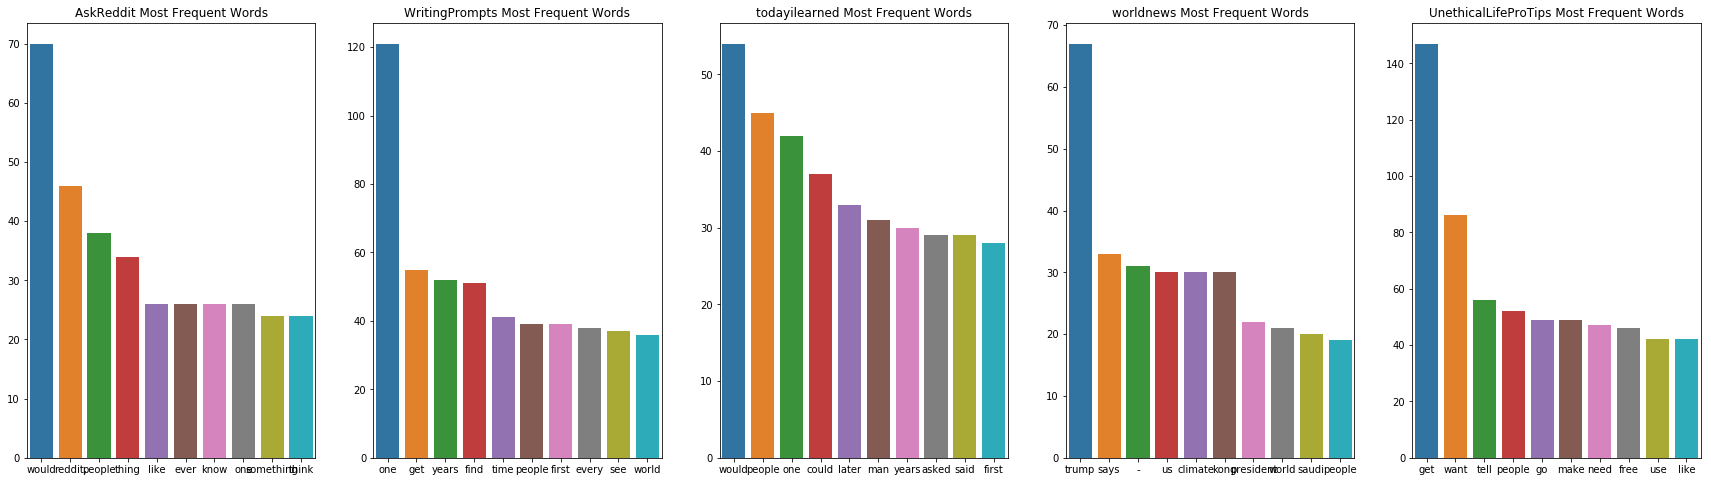

In [36]:
# Top ten words by sub (no stopwords)
from collections import defaultdict
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

fig, axs = plt.subplots(1, 5, figsize=(30, 8))
for i,ax in enumerate(axs):
    data = df_title.loc[df_title['subreddit'] == subs[i]]
    
    corpus = ''
    for title in data['title']:
        corpus += title
    
    word_freq_dict = defaultdict(int)
    for word in [word for word in corpus.split() if word not in stop_words]:
        word_freq_dict[word] += 1
        
    x = []
    y = []
    
    for word, count in sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True):
        x.append(word)
        y.append(count)        
    
    sns.barplot(x=x[:10], y=y[:10], ax=axs[i]).set_title(f'{subs[i]} Most Frequent Words')
    
plt.savefig('imgs/ind_word_count_bar_no_stopwords.png')